# 1. Import and Install Dependencies

In [1]:
!git clone https://github.com/ElyasAmri/icamp-AI-graduation-project

Cloning into 'icamp-AI-graduation-project'...
remote: Enumerating objects: 183, done.
remote: Total 183 (delta 0), reused 0 (delta 0), pack-reused 183 (from 1)
Receiving objects: 100% (183/183), 243.07 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (96/96), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/AllData.zip -d /content/icamp-AI-graduation-project/Sign\ To\ Text/Notebooks/. > /dev/null 2>&1

In [4]:
!cp -r /content/icamp-AI-graduation-project/Sign\ To\ Text/Notebooks/AllData/* /content/icamp-AI-graduation-project/Sign\ To\ Text/Notebooks/.

In [5]:
rm -rf /content/icamp-AI-graduation-project/Sign\ To\ Text/Notebooks/AllData/AllData

In [6]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import models
from keras import layers
from tensorflow.python.client import device_lib


In [7]:
# Check GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4601846504200169449
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17390447166413958798
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 2. Load Data

In [8]:
dataset_path1 = os.path.join(r"icamp-AI-graduation-project/Sign To Text/Notebooks", r"AllData/Characters/Peter/Characters_Dataset")
dataset_path2 = os.path.join(r"icamp-AI-graduation-project/Sign To Text/Notebooks", r"AllData/Characters/Aya")

In [9]:
classes = [ 'aleff',  'bb', 'ta', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'thal', 'ra', \
         'zay' , 'seen', 'sheen',  'saad', 'dhad','taa', 'dha', 'ain', 'ghain','fa', \
          'gaaf', 'kaaf','laam', 'meem', 'nun', 'ha', 'waw','ya']

### Prepare Data for VGG16

In [10]:
dataset1 = image_dataset_from_directory(dataset_path1,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224),color_mode='rgb',label_mode= 'categorical',
                                             class_names=classes)

Found 2800 files belonging to 28 classes.


In [11]:
dataset2 = image_dataset_from_directory(dataset_path2,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224),color_mode='rgb',label_mode= 'categorical',
                                             class_names=classes)

Found 2800 files belonging to 28 classes.


In [12]:
# Combine 2 Datasets
dataset = dataset1.concatenate(dataset2)
# Get No. of Batches
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=176>

In [13]:
# Split to Training and Validation
dataset_batches = tf.data.experimental.cardinality(dataset)
# 30% of Data To Validation and Testing
validation_dataset = dataset.take(dataset_batches // 7)
# 70% of Data To Training
training_dataset = dataset.skip(dataset_batches // 7)


In [14]:
# Split the Validation to valid and test
val_batches = tf.data.experimental.cardinality(validation_dataset)
testing_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


In [15]:
# To Increase up Feeding Data To Network
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Display The No. of Batches
print(tf.data.experimental.cardinality(training_dataset))
print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(testing_dataset))

tf.Tensor(151, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)


# 3. Initialize Data Augmentation Layer

In [17]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [18]:
# Custom Layer for Brightness and Contrast
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.6, 1.8],
                 brightness_delta=[-0.3, 0.3], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta

    def call(self, images, training=True):
        if not training:
            return images

        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])

        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 255)
        return images

In [19]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    # Make a Random Rotation
    tf.keras.layers.RandomRotation(0.05),
    # Make a Random Width
    tf.keras.layers.RandomWidth((-.2,.2), interpolation='bilinear'),
    # Make a Random Height
    tf.keras.layers.RandomHeight((-.2,.2), interpolation='bilinear'),
    # Make a Random Translation
    tf.keras.layers.RandomTranslation((-0.1, 0.1),(-0.1, 0.1),fill_mode='constant'),
    # Resize image to 224 x 224 pixels again after Widthing,Heighting
    tf.keras.layers.Resizing(224,224,interpolation='bilinear'),
    # Make a Random Color
    RandomColorDistortion()
])

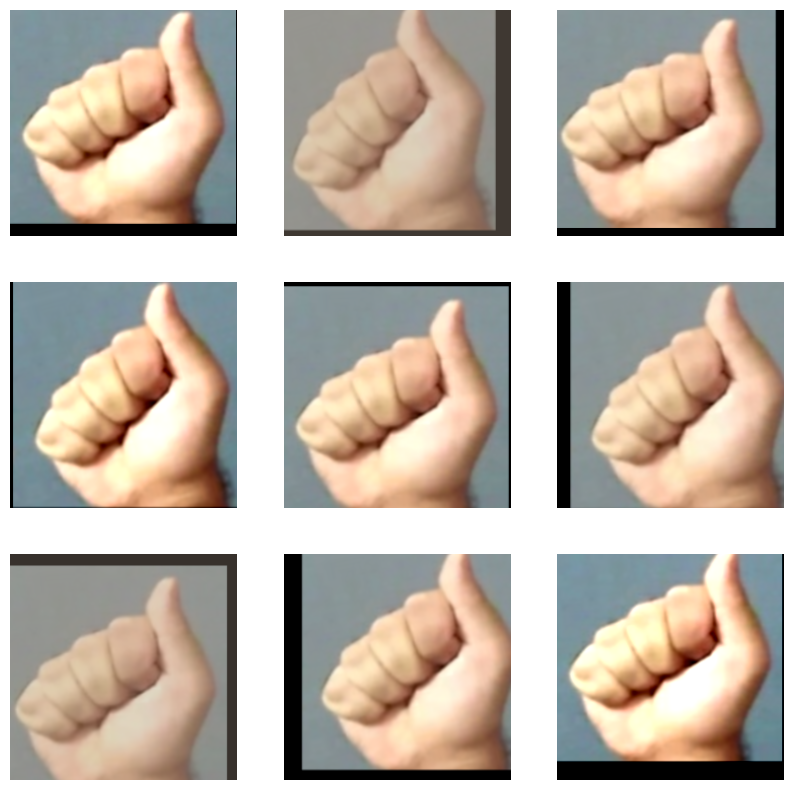

In [20]:
# Show The Output of Augmentation Layer for Same Image
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [21]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

# 4. Model VGG16

In [22]:
# Get The Base Network
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
# Freeze Conv Layer
conv_base.trainable = False

##### Build a Network for Training

In [24]:
# Build a Network for Training
inp = layers.Input(shape=(224,224,3))
x = data_augmentation(inp)
x = (conv_base)(inp)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs=inp, outputs=[outs])

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,929,692 (68.40 MB)

 Trainable params: 3,215,004 (12.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [27]:
log_dir = os.path.join('Logs/vgg16_transfer_learning')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.

# copy Models/vgg16_transfer_learning.h5 to Models/vgg16_transfer_learning.keras
import shutil
os.listdir('./icamp-AI-graduation-project/Sign To Text/Notebooks/Models/')
shutil.copy("icamp-AI-graduation-project/Sign To Text/Notebooks/Models/VGG_transfer_learning.h5", "icamp-AI-graduation-project/Sign To Text/Notebooks/Models/VGG_transfer_learning.keras")
mc = ModelCheckpoint(os.path.join(r"icamp-AI-graduation-project/Sign To Text/Notebooks",'Models/vgg_transfer_learning.keras'), monitor='val_acc', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=5)
callbacks = [tb_callback,mc,es]

In [28]:
model.fit(training_dataset,epochs=50,callbacks=[callbacks], validation_data = validation_dataset)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - acc: 0.6386 - loss: 3.4595
Epoch 1: val_acc improved from -inf to 0.96875, saving model to icamp-AI-graduation-project/Sign To Text/Notebooks/Models/vgg_transfer_learning.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 210ms/step - acc: 0.6398 - loss: 3.4457 - val_acc: 0.9688 - val_loss: 0.1069
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - acc: 0.9959 - loss: 0.0137
Epoch 2: val_acc improved from 0.96875 to 0.99760, saving model to icamp-AI-graduation-project/Sign To Text/Notebooks/Models/vgg_transfer_learning.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - acc: 0.9959 - loss: 0.0137 - val_acc: 0.9976 - val_loss: 0.0129
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - acc: 1.0000 - loss: 5.9352e-05
Epoch 3: val_acc improved from 0.99760 to 1.00000, saving model to icamp-AI-graduation-project/Sign To Text/Notebooks/Models/vgg_transfer_learning.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - acc: 1.0000 - loss: 5.922

In [30]:
# Save The Last Model
model.save('icamp-AI-graduation-project/Sign To Text/Notebooks/Models/last_training_model.keras')

## 4.1 Model Evaluation

In [31]:
model.evaluate(testing_dataset)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - acc: 1.0000 - loss: 9.7078e-06


[6.711614787491271e-06, 1.0]